# Flower Classification with VGG16
### Author: Salma OUARDI
Dataset: [Flowers Recognition](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition)

### On import la base de données depuis Kaggle

In [7]:
%pip install kaggle


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

# ! kaggle datasets download alxmamaev/flowers-recognition
# ! unzip flowers-recognition.zip

### On verifie qu'on a un GPU 

In [9]:
#' ' means CPU whereas '/device:G:0' means GPU
import tensorflow as tf
tf.test.gpu_device_name()

2024-11-21 17:06:10.240647: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 17:06:11.162581: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2024-11-21 17:06:11.162646: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2024-11-21 17:06:11.171736: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2024-11-21 17:06:11.483655: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 2 compatible adapters.
2024-11-21 17:06:11.764951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the fo

'/device:GPU:0'

ble_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 17714 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-21 17:06:11.949845: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2024-11-21 17:06:11.949868: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:1 with 14553 MB memory) -> physical PluggableDevice (device: 1, name: DML, pci bus id: <undefined>)


In [10]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

ln: failed to create symbolic link '/usr/bin/nvidia-smi': Permission denied
  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7409 sha256=04c5f8d82ce7f85828dee30345ed8fe6ce6025dacd949ca226310ba731f9b492
  Stored in directory: /home/logic/.cache/pip/wheels/2b/b5/24/fbb56595c286984f7315ee31821d6121e1b9828436021a88b3
Successfully built gputil

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.1/128.1 kB 4.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Gen RAM Free: 11.4 GB  | Proc size: 500.6 MB
GPU RAM Free: 3100MB | Used: 855MB | Util  21% | Total 4096MB


### On import les librairies

In [ ]:
import os
import shutil
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import matplotlib.image as mimg

# tensorflow 2.16 allows 
# from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
from keras import optimizers

from keras import layers
from keras import models
from keras import optimizers

import tensorflow as tf

In [12]:
# Check for the directory and if it doesn't exist, make one.
cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
    
# make the models sub-directory
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [13]:
# original dataset folder, you can see above
flowers_path = Path('/home/logic/_wsl_workspace/google-colab-playlist/VGG16/with_feature_extraction/flower_photos')

## On prepare explore la dataset

In [14]:
# Each species of flower is contained in a separate folder. Get all the sub directories
flower_types = os.listdir(flowers_path)
print("Types of flowers found: ", len(flower_types))
print("Categories of flowers: ", flower_types)

Types of flowers found:  5
Categories of flowers:  ['daisy', 'dandelion', 'sunflowers', 'tulips', 'roses']


In [15]:
# A list that is going to contain tuples: (species of the flower, corresponding image path)
flowers = []

for species in flower_types:
    # Get all the file names
    all_flowers = os.listdir(flowers_path / species)
    # Add them to the list
    for flower in all_flowers:
        flowers.append((species, str(flowers_path /species) + '/' + flower))

# Build a dataframe        
flowers = pd.DataFrame(data=flowers, columns=['category', 'image'], index=None)
flowers.head()

,category,image
0,daisy,/home/logic/_wsl_workspace/google-colab-playli...
1,daisy,/home/logic/_wsl_workspace/google-colab-playli...
2,daisy,/home/logic/_wsl_workspace/google-colab-playli...
3,daisy,/home/logic/_wsl_workspace/google-colab-playli...
4,daisy,/home/logic/_wsl_workspace/google-colab-playli...


In [16]:
# Let's check how many samples for each category are present
print("Total number of flowers in the dataset: ", len(flowers))
fl_count = flowers['category'].value_counts()
print("Flowers in each category: ")
print(fl_count)

Total number of flowers in the dataset:  7172
Flowers in each category: 
category
dandelion     1750
tulips        1538
sunflowers    1356
roses         1270
daisy         1258
Name: count, dtype: int64


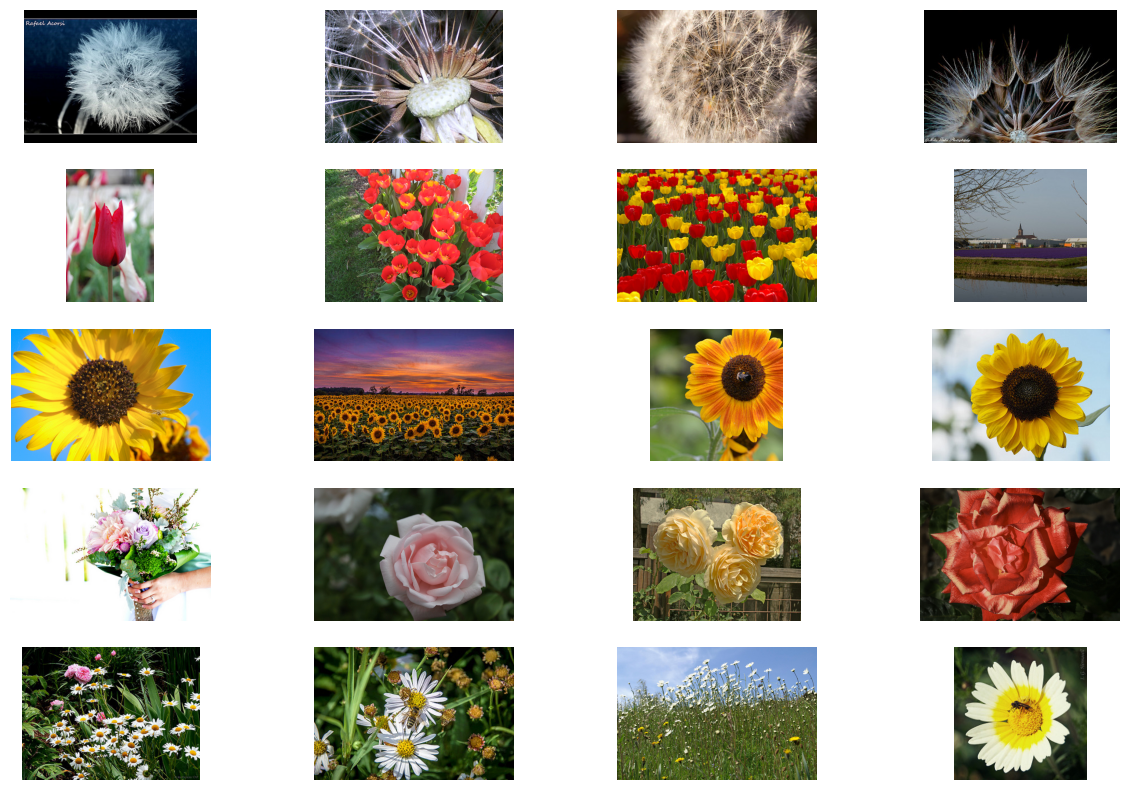

In [17]:
# Let's visualize some flowers from each category

# A list for storing names of some random samples from each category
random_samples = []

# Get samples fom each category 
for category in fl_count.index:
    samples = flowers['image'][flowers['category'] == category].sample(4).values
    for sample in samples:
        random_samples.append(sample)

# Plot the samples
f, ax = plt.subplots(5,4, figsize=(15,10))
for i,sample in enumerate(random_samples):
    ax[i//4, i%4].imshow(mimg.imread(random_samples[i]))
    ax[i//4, i%4].axis('off')
plt.show()    

### On va créer deux dossier 'Train' et 'Valid' pour notre modéle

In [18]:
# Make a parent directory `data` and two sub directories `train` and `valid`
%mkdir -p data/train
%mkdir -p data/valid

# Inside the train and validation sub=directories, make sub-directories for each catgeory
%cd data
%mkdir -p train/daisy
%mkdir -p train/tulips
%mkdir -p train/sunflowers
%mkdir -p train/roses
%mkdir -p train/dandelion

%mkdir -p valid/daisy
%mkdir -p valid/tulips
%mkdir -p valid/sunflowers
%mkdir -p valid/roses
%mkdir -p valid/dandelion

%cd ..

/home/logic/_wsl_workspace/google-colab-playlist/data


/home/logic/.pyenv/versions/3.9.20/envs/tf_intel/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/logic/_wsl_workspace/google-colab-playlist


### On import nos catégories dans les deux dossiers 

In [19]:
for category in fl_count.index:
    samples = flowers['image'][flowers['category'] == category].values
    #perm = np.random.permutation(samples)
    # Copy first 100 samples to the validation directory and rest to the train directory

    print(samples[0])
    
    for i in range(100):
        name = samples[i].split('/')[-1]
        shutil.copyfile(samples[i],'./data/valid/' + str(category) + '/'+ name)
    for i in range(100,len(samples)):
        name = samples[i].split('/')[-1]
        shutil.copyfile(samples[i],'./data/train/' + str(category) + '/' + name)

/home/logic/_wsl_workspace/google-colab-playlist/VGG16/with_feature_extraction/flower_photos/dandelion/dandelion_140951103_69847c0b7c.jpg
/home/logic/_wsl_workspace/google-colab-playlist/VGG16/with_feature_extraction/flower_photos/tulips/tulips_8572847041_d0cc07861f_n.jpg
/home/logic/_wsl_workspace/google-colab-playlist/VGG16/with_feature_extraction/flower_photos/sunflowers/4689061249_6498da5013.jpg
/home/logic/_wsl_workspace/google-colab-playlist/VGG16/with_feature_extraction/flower_photos/roses/3829990289_c0c3821e4d_m.jpg
/home/logic/_wsl_workspace/google-colab-playlist/VGG16/with_feature_extraction/flower_photos/daisy/daisy_19813618946_93818db7aa_m.jpg


### Comme modéle, on utilise VGG16 qui est un modéle Pretrained

In [20]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(240, 240, 3))

2024-11-21 17:06:21.668507: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 17:06:21.668559: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 17:06:21.668608: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 17714 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-21 17:06:21.668627: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:1 with 14553 MB memory) -> physical PluggableDevice (device: 1, name: 

In [21]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0     

In [22]:
base_dir = './data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')

## Feature Extraction

In [23]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='softmax'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 6

In [28]:
batch_size = 32
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(240, 240),  # all images will be resized to 240x240
        batch_size=batch_size,
        class_mode='categorical')  # more than two classes

validation_generator = test_datagen.flow_from_directory(
        'data/valid',
        target_size=(240, 240),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False
)

Found 6672 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [ ]:

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['acc'])

In [3]:
history = {}

with tf.device('/GPU:1'):
    history = model.fit_generator(
            train_generator,
            epochs=2, # originally 30 epochs
            validation_data=validation_generator)

2024-11-21 17:04:23.293216: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 17:04:23.293513: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (NVIDIA T400 4GB)
2024-11-21 17:04:23.411544: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 1 (Intel(R) Iris(R) Xe Graphics)
2024-11-21 17:04:23.461079: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 17:04:23.461102: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Yo

NameError: name 'model' is not defined

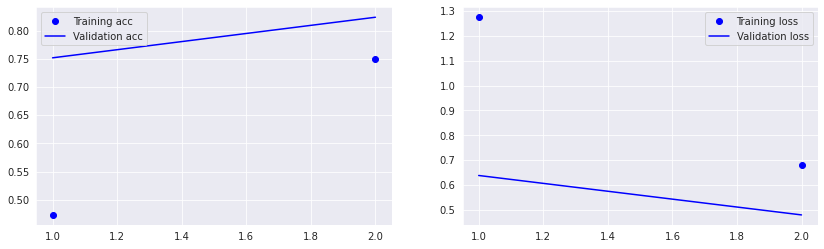

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()


In [ ]:
model_2_val = val_acc[-1]
print("Validation Accuracy: ", model_2_val)

Validation Accuracy:  0.8240000009536743


# Fine Tuning

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0     

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=3,# originally 6 epochs
    validation_data=validation_generator,
    validation_steps=50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/3
100/100 [==============================] - 80s 791ms/step - loss: 0.2311 - acc: 0.7963 - val_loss: 0.1389 - val_acc: 0.8780
Epoch 2/3
100/100 [==============================] - 59s 585ms/step - loss: 0.1797 - acc: 0.8385
Epoch 3/3
100/100 [==============================] - 62s 614ms/step - loss: 0.1614 - acc: 0.8508


In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [ ]:
model_3_val = val_acc[-1]
print("Validation Accuracy: ", model_3_val)

### 85% Accuracy using VGG16.